In [1]:
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
model = ChatOllama(model = "qwen3:1.7b")

In [3]:
class EvaluationSchema(BaseModel):
    feedback : str = Field(description= 'Detailed feedback about essay')
    score : int = Field(desciption= 'Score out of 10', ge=0, le=10)

/tmp/ipykernel_275736/2382860037.py:3: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'desciption'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  score : int = Field(desciption= 'Score out of 10', ge=0, le=10)


In [4]:
structured_model = model.with_structured_output(EvaluationSchema)

In [5]:
class EssayEvaluationState(TypedDict):
    topic : str
    essay : str
    clarity_of_thought_feedback : str
    depth_of_analysis_feedback : str
    language_proficiency_feedback : str
    overall_feedback : str
    individual_score : Annotated[list[int], operator.add]
    overall_score: float
    result: str

In [6]:
def clarity_of_thought_evaluator(state: EssayEvaluationState) -> EssayEvaluationState:
    topic = state['topic']
    essay = state['essay']
    prompt = f'''You are an UPSC exam moderator, UPSC is an esteemed and competitive exam in India for getting into Civil Services.
    You are given a topic and an essay written over it, your goal is to evaluate this essay \n {essay} on this topic \n {topic} on the basis 
    of CLARITY OF THOUGHT and generate a score for it out of 10'''
    response = structured_model.invoke(prompt)
    return {'clarity_of_thought_feedback': response.feedback, 'individual_score': [response.score]}

In [7]:
def depth_of_analysis_evaluator(state: EssayEvaluationState) -> EssayEvaluationState:
    topic = state['topic']
    essay = state['essay']
    prompt = f'''You are an UPSC exam moderator, UPSC is an esteemed and competitive exam in India for getting into Civil Services.
    You are given a topic and an essay written over it, your goal is to evaluate this essay \n {essay} on this topic \n {topic} on the basis 
    of DEPTH OF ANALYSIS about the topic and generate a score for it out of 10'''
    response = structured_model.invoke(prompt)
    return {'depth_of_analysis_feedback': response.feedback, 'individual_score': [response.score]}

In [8]:
def language_proficiency_evaluator(state: EssayEvaluationState) -> EssayEvaluationState:
    topic = state['topic']
    essay = state['essay']
    prompt = f'''You are an UPSC exam moderator, UPSC is an esteemed and competitive exam in India for getting into Civil Services.
    You are given a topic and an essay written over it, your goal is to evaluate this essay \n {essay} on this topic \n {topic} on the basis 
    of LANGUAGE PROFICIENCY and generate a score for it out of 10'''
    response = structured_model.invoke(prompt)
    return {'language_proficiency_feedback': response.feedback, 'individual_score': [response.score]}
    

In [ ]:
def calculate_result(state: EssayEvaluationState) -> EssayEvaluationState:
    prompt = f'''Given the three feedbacks on the essay on following {state["topic"]} followed by feedback on clarity of thought \n
    {state['clarity_of_thought_feedback']} \n feedback on depth of analysis \n {state['depth_of_analysis_feedback']} \n feedback on 
    language proficiency \n {state['language_proficiency_feedback']}, generate an overall feedback'''
    response = model.invoke(prompt).content
    feedback = response
    overall_score = sum(state['individual_score'])/len(state['individual_score'])
    if(sum(state['individual_score']) >= 15):
        state['result'] = "Passed"
    else:
        state['result'] = "Better luck next time"
    
    return {'overall_feedback': feedback, 'overall_score': overall_score}

In [10]:
graph = StateGraph(EssayEvaluationState)

graph.add_node('COT Evaluator', clarity_of_thought_evaluator)
graph.add_node('DOA Evaluator', depth_of_analysis_evaluator)
graph.add_node('LP Evaluator', language_proficiency_evaluator)
graph.add_node('Get Result', calculate_result)

graph.add_edge(START, 'COT Evaluator')
graph.add_edge(START, 'DOA Evaluator')
graph.add_edge(START, 'LP Evaluator')
graph.add_edge('COT Evaluator', 'Get Result')
graph.add_edge('DOA Evaluator', 'Get Result')
graph.add_edge('LP Evaluator', 'Get Result')
graph.add_edge('Get Result', END)

workflow = graph.compile()





In [11]:
response = workflow.invoke({'topic': 'Racism in coorperate sector in India', 'essay': 'The racism in corporate sector is not good'})
print(response)

{'topic': 'Racism in coorperate sector in India', 'essay': 'The racism in corporate sector is not good', 'clarity_of_thought_feedback': "The essay on 'Racism in the Corporate Sector in India' demonstrates a basic understanding of the topic but lacks clarity of thought and structural coherence. The argument is fragmented, with insufficient development of key points and a weak conclusion. While the content touches on relevant issues like wage disparity and discrimination, it fails to present a cohesive argument. The essay could benefit from a stronger thesis statement, logical organization, and clearer connections between ideas. A score of 6.5 is appropriate, as it reflects the essay's partial engagement with the topic while highlighting its structural and conceptual weaknesses.", 'depth_of_analysis_feedback': 'The essay addresses the topic of racism in the corporate sector in India but lacks depth and comprehensive analysis. It presents a general statement without exploring specific dim

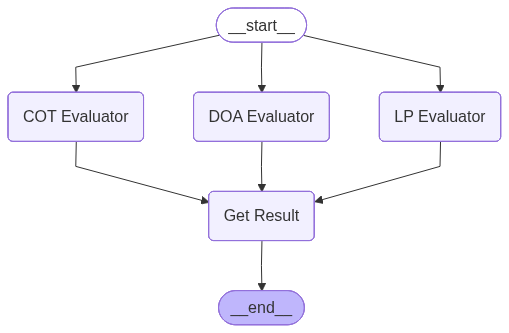

In [12]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())